<div>
    <h1 id = "preparation"
        style = "background-color: #9f424d;
                 border-radius: 25px;
                 border-left:40px #b3b6b5 solid;
                 border-right:40px #b3b6b5 solid;
                 color: #f8f8f8;
                 line-height: 28px;
                 padding: 14px 0px 15px 15px; 
                 text-align: center;
                 font-size: 25px;
                 font-weight: bold;
                 font-family: Cambria;">1. Preparation 🧰
        <a class="anchor-link" id="preparation" href="https://www.kaggle.com/code/harits/https://www.kaggle.com/harits/people-detection-and-tracking-yolov8-bytetrack#preparation">¶</a>
    </h1>
</div>

In [1]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# System
import os
import gc
import shutil
import time
import glob

# Main
import random
import numpy as np 
import pandas as pd
import json
import cv2
from tqdm import tqdm
tqdm.pandas()
from scipy.io import loadmat

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from IPython.display import Image, display, HTML

In [2]:
if(os.path.exists("datasets")==False):
    os.mkdir("datasets")
    
if(os.path.exists("datasets/images")==False):
    os.mkdir("datasets/images")   
if(os.path.exists("datasets/images/train")==False):
    os.mkdir("datasets/images/train")
if(os.path.exists("datasets/images/val")==False):
    os.mkdir("datasets/images/val")
    
if(os.path.exists("datasets/labels")==False):
    os.mkdir("datasets/labels")   
if(os.path.exists("datasets/labels/train")==False):
    os.mkdir("datasets/labels/train")
if(os.path.exists("datasets/labels/val")==False):
    os.mkdir("datasets/labels/val")
    
if(os.path.exists("csv_files")==False):
    os.mkdir("csv_files")
if(os.path.exists("sample_videos")==False):
    os.mkdir("sample_videos")
if(os.path.exists("output_videos")==False):
    os.mkdir("output_videos")

In [3]:
debug = False
if(debug):
    train_fol = "3" 
    val_fol = "2"
    track_fol = "2"
    epochs = 3
else:
    train_fol = ""
    val_fol = ""
    track_fol = ""
    epochs = 30

<div>
    <h1 id = "data-preprocessing"
        style = "background-color: #9f424d;
                 border-radius: 25px;
                 border-left:40px #b3b6b5 solid;
                 border-right:40px #b3b6b5 solid;
                 color: #f8f8f8;
                 line-height: 28px;
                 padding: 14px 0px 15px 15px; 
                 text-align: center;
                 font-size: 25px;
                 font-weight: bold;
                 font-family: Cambria;">2. Data Preprocessing 🧹
        <a class="anchor-link" id="data-preprocessing" href="https://www.kaggle.com/harits/people-detection-and-tracking-yolov8-bytetrack#data-preprocessing">¶</a>
    </h1>
</div>

<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">2.1. Generate Annotations</h2>
</div>

In [4]:
# Generate Annotations
def convertBoxFormat(box):
    (box_x_left, box_y_top, box_w, box_h) = box
    (image_w, image_h) = (640, 480)
    dw = 1./image_w
    dh = 1./image_h
    x = (box_x_left + box_w / 2.0) * dw
    y = (box_y_top + box_h / 2.0) * dh
    w = box_w * dw
    h = box_h * dh
    return (x, y, w, h)
    
annotation_dir = '/kaggle/input/caltechpedestriandataset/annotations/annotations/*'
classes = ['person']
number_of_truth_boxes = 0

img_id_list = []
label_list = []
split_list = []
num_annot_list = []

# Sets
for sets in tqdm(sorted(glob.glob(annotation_dir))):
    set_id = os.path.basename(sets)
    set_number = int(set_id.replace('set', ''))
    split_dataset = "train" if set_number <=5 else "val"
    
    # Videos
    for vid_annotations in sorted(glob.glob(sets + "/*.vbb")):
        video_id = os.path.splitext(os.path.basename(vid_annotations))[0] # Video ID
        vbb = loadmat(vid_annotations) # Read VBB File
        obj_lists = vbb['A'][0][0][1][0] # Annotation List
        obj_lbl = [str(v[0]) for v in vbb['A'][0][0][4][0]] # Label List
        
        # Frames
        for frame_id, obj in enumerate(obj_lists):
            if(len(obj)>0):
                # Labels
                labels = ''
                num_annot = 0
                for pedestrian_id, pedestrian_pos in zip(obj['id'][0], obj['pos'][0]):
                    pedestrian_id = int(pedestrian_id[0][0]) - 1 # Pedestrian ID
                    pedestrian_pos = pedestrian_pos[0].tolist() # Pedestrian BBox
                    # class filter and height filter: here example for medium distance
                    if obj_lbl[pedestrian_id] in classes and pedestrian_pos[3] >= 75 and pedestrian_pos[3] <= 250:
                        yolo_box_format = convertBoxFormat(pedestrian_pos) # Convert BBox to YOLO Format
                        labels += '0 ' + ' '.join([str(n) for n in yolo_box_format]) + '\n'
                        num_annot += 1
                        number_of_truth_boxes += 1
                
                # Check Labels
                if not labels:
                    continue

                image_id = set_id + '_' + video_id + '_' + f"{frame_id:04d}"
                img_id_list.append(image_id)
                label_list.append(labels)
                split_list.append(split_dataset)
                num_annot_list.append(num_annot)
    
print("Number of Ground Truth Annotation Box:", number_of_truth_boxes)

df_caltech_annot = pd.DataFrame({
    "image_id": img_id_list,
    "label": label_list,
    "split": split_list,
    "num_annot": num_annot_list
})

df_caltech_annot["set_id"] = df_caltech_annot["image_id"].apply(lambda x: x.split("_")[0])
df_caltech_annot["video_id"] = df_caltech_annot["image_id"].apply(lambda x: x.split("_")[1])
df_caltech_annot["frame_id"] = df_caltech_annot["image_id"].apply(lambda x: int(x.split("_")[2]))

df_caltech_annot.to_csv("csv_files/frame_metadata.csv", index=False)
df_caltech_annot

100%|██████████| 11/11 [00:15<00:00,  1.37s/it]


Number of Ground Truth Annotation Box: 50775


,image_id,label,split,num_annot,set_id,video_id,frame_id
0,set00_V001_0043,0 0.9132596380002878 0.40396814269354026 0.033...,train,1,set00,V001,43
1,set00_V001_0044,0 0.9201749299762035 0.40417785997183425 0.032...,train,1,set00,V001,44
2,set00_V001_0045,0 0.9272476390096147 0.4043875772501283 0.0326...,train,1,set00,V001,45
3,set00_V001_0046,0 0.9336984094848542 0.4093106823792465 0.0327...,train,1,set00,V001,46
4,set00_V001_0047,0 0.9406430902087917 0.41283289921316346 0.032...,train,1,set00,V001,47
...,...,...,...,...,...,...,...
30061,set10_V011_1729,0 0.09544750372975269 0.43736416003599493 0.05...,val,1,set10,V011,1729
30062,set10_V011_1730,0 0.08342295840437615 0.436796882400303 0.0577...,val,1,set10,V011,1730
30063,set10_V011_1731,0 0.07139841307899962 0.43622960476461103 0.05...,val,1,set10,V011,1731
30064,set10_V011_1732,0 0.05937386775362308 0.4356623271289191 0.058...,val,1,set10,V011,1732


<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">2.2. Filter Image Files</h2>
</div>

In [5]:
df_set_video = df_caltech_annot.groupby(["set_id", "video_id", "split"])["image_id"].count().reset_index()
df_set_video = df_set_video.rename(columns={"image_id": "total_image"})

df_set_video_train = df_set_video[df_set_video["split"]=="train"].reset_index(drop=True)
df_set_video_val = df_set_video[df_set_video["split"]=="val"].reset_index(drop=True)

display(df_set_video_train.head())
display(df_set_video_val.head())

total_train_image = sum(df_set_video_train["total_image"])
total_val_image = sum(df_set_video_val["total_image"])
print("Number of Train:", total_train_image)
print("Number of Val:", total_val_image)

df_set_video_train = df_set_video_train.groupby("set_id")["video_id"].count().reset_index()
df_set_video_val = df_set_video_val.groupby("set_id")["video_id"].count().reset_index()
df_set_video_count = pd.concat([df_set_video_train, df_set_video_val], ignore_index=True)
df_set_video_count = df_set_video_count.rename(columns={"video_id": "total_video"})
display(df_set_video_count)

,set_id,video_id,split,total_image
0,set00,V001,train,539
1,set00,V002,train,408
2,set00,V004,train,137
3,set00,V006,train,1143
4,set00,V007,train,892


,set_id,video_id,split,total_image
0,set06,V000,val,50
1,set06,V001,val,115
2,set06,V002,val,322
3,set06,V003,val,23
4,set06,V005,val,27


Number of Train: 18041
Number of Val: 12025


,set_id,total_video
0,set00,12
1,set01,6
2,set02,3
3,set03,9
4,set04,10
5,set05,12
6,set06,15
7,set07,12
8,set08,5
9,set09,11


In [6]:
df_train_filtered = pd.DataFrame()
df_val_filtered = pd.DataFrame()

set_id_list = list(df_caltech_annot["set_id"].unique())

for i, set_id in enumerate(set_id_list):
    df_set_id = df_set_video[df_set_video["set_id"]==set_id].reset_index(drop=True)
    video_id_list = list(df_set_id["video_id"].unique())
    
    for j, vid_id in enumerate(video_id_list):
        df_video_id = df_caltech_annot[(df_caltech_annot["set_id"]==set_id) & (df_caltech_annot["video_id"]==vid_id)].reset_index(drop=True)
        frame_total = df_video_id.shape[0]
        if(i <= 5): # 10000 Train Images
            limit = int(round((frame_total / total_train_image) * 10000, 0))
            df_video_id = df_video_id[:limit]
            df_train_filtered = pd.concat([df_train_filtered, df_video_id])  # Use concat to concatenate DataFrames
        else: # 2500 Val Images
            limit = int(round((frame_total / total_val_image) * 2500, 0))
            df_video_id = df_video_id[:limit]
            df_val_filtered = pd.concat([df_val_filtered, df_video_id])  # Use concat to concatenate DataFrames

df_train_filtered = df_train_filtered.reset_index(drop=True)
df_val_filtered = df_val_filtered.reset_index(drop=True)

display(df_train_filtered)
display(df_val_filtered)

df_train_filtered.to_csv("csv_files/train_frame_filtered.csv", index=False)
df_val_filtered.to_csv("csv_files/val_frame_filtered.csv", index=False)


,image_id,label,split,num_annot,set_id,video_id,frame_id
0,set00_V001_0043,0 0.9132596380002878 0.40396814269354026 0.033...,train,1,set00,V001,43
1,set00_V001_0044,0 0.9201749299762035 0.40417785997183425 0.032...,train,1,set00,V001,44
2,set00_V001_0045,0 0.9272476390096147 0.4043875772501283 0.0326...,train,1,set00,V001,45
3,set00_V001_0046,0 0.9336984094848542 0.4093106823792465 0.0327...,train,1,set00,V001,46
4,set00_V001_0047,0 0.9406430902087917 0.41283289921316346 0.032...,train,1,set00,V001,47
...,...,...,...,...,...,...,...
9995,set05_V012_0463,0 0.6150727153784218 0.44613023349436387 0.068...,train,3,set05,V012,463
9996,set05_V012_0464,0 0.6183738425925924 0.4472574476650563 0.0691...,train,3,set05,V012,464
9997,set05_V012_0465,0 0.6216749698067631 0.4483846618357487 0.0698...,train,3,set05,V012,465
9998,set05_V012_0466,0 0.6249760970209337 0.4495118760064411 0.0704...,train,3,set05,V012,466


,image_id,label,split,num_annot,set_id,video_id,frame_id
0,set06_V000_0272,0 0.12745660746235818 0.45532887301498437 0.05...,val,1,set06,V000,272
1,set06_V000_0273,0 0.12537228551704158 0.4567743326264715 0.052...,val,1,set06,V000,273
2,set06_V000_0274,0 0.12321162631467948 0.4581447419812191 0.053...,val,1,set06,V000,274
3,set06_V000_0275,0 0.1210509671123174 0.4595151513359667 0.0535...,val,1,set06,V000,275
4,set06_V000_0276,0 0.119307780048436 0.45903686683006545 0.0546...,val,1,set06,V000,276
...,...,...,...,...,...,...,...
2493,set10_V011_0360,0 0.9008835022651756 0.4751380896561523 0.0809...,val,2,set10,V011,360
2494,set10_V011_0361,0 0.9032056079724717 0.47521323726753173 0.080...,val,2,set10,V011,361
2495,set10_V011_0362,0 0.905537775587288 0.4752883848789113 0.08045...,val,2,set10,V011,362
2496,set10_V011_0363,0 0.9078800051096245 0.4753635324902908 0.0802...,val,2,set10,V011,363


<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">2.3. Generate Image Files</h2>
</div>

In [7]:
# https://github.com/simonzachau/caltech-pedestrian-dataset-to-yolo-format-converter
# Generate Images from Video Files
def save_img(dir_path, fn, i, frame):
    cv2.imwrite('{}/{}_{}_{}.png'.format(
        dir_path, os.path.basename(dir_path), os.path.basename(fn).split('.')[0], f"{i:04d}"), 
        frame)
def convert_caltech(split, df):
    # Directory Path
    print(split)
    input_dir = "/kaggle/input/caltechpedestriandataset"
    output_dir = "datasets/images"
    if(split=="Train"):
        output_dir = os.path.join(output_dir, "train")
    else:
        output_dir = os.path.join(output_dir, "val")
    output_dir = os.path.join(output_dir, "caltechpedestriandataset")
    if(os.path.exists(output_dir)==False):
        os.mkdir(output_dir)
    
    # Sets
    sets_list = sorted(glob.glob(os.path.join(input_dir, split+"/*")))
    print("Total Sets:", len(sets_list))
    for dname in sets_list:
        print(dname)
        dname2 = dname.split("/")[-1]
        output_dir2 = os.path.join(output_dir, dname2)
        if(os.path.exists(output_dir2)==False):
            os.mkdir(output_dir2)
        df_filtered = df[df["set_id"]==dname2].reset_index(drop=True)
        
        # Videos
        videos_list = list(df_filtered["video_id"].unique())
        print("Total Videos:", len(videos_list))
        for i, vd in enumerate(videos_list):
            fn = os.path.join(dname, dname2, vd+".seq")
            print(fn)
            cap = cv2.VideoCapture(fn)
            df_filtered2 = df_filtered[df_filtered["video_id"]==vd]
            
            # Frames
            frame_set = set(df_filtered2["frame_id"].unique())
            limit = len(frame_set)
            print("Total Frames:", limit)
            j = 0
            k = 0
            while True:
                ret, frame = cap.read()
                if(j in frame_set):
                    save_img(output_dir2, fn, j, frame)
                    k += 1
                    if(k==limit):
                        break
                j += 1

In [8]:
convert_caltech("Train", df_train_filtered)

Train
Total Sets: 6
/kaggle/input/caltechpedestriandataset/Train/set00
Total Videos: 12
/kaggle/input/caltechpedestriandataset/Train/set00/set00/V001.seq
Total Frames: 299
/kaggle/input/caltechpedestriandataset/Train/set00/set00/V002.seq
Total Frames: 226
/kaggle/input/caltechpedestriandataset/Train/set00/set00/V004.seq
Total Frames: 76
/kaggle/input/caltechpedestriandataset/Train/set00/set00/V006.seq
Total Frames: 634
/kaggle/input/caltechpedestriandataset/Train/set00/set00/V007.seq
Total Frames: 494
/kaggle/input/caltechpedestriandataset/Train/set00/set00/V008.seq
Total Frames: 425
/kaggle/input/caltechpedestriandataset/Train/set00/set00/V009.seq
Total Frames: 526
/kaggle/input/caltechpedestriandataset/Train/set00/set00/V010.seq
Total Frames: 517
/kaggle/input/caltechpedestriandataset/Train/set00/set00/V011.seq
Total Frames: 256
/kaggle/input/caltechpedestriandataset/Train/set00/set00/V012.seq
Total Frames: 258
/kaggle/input/caltechpedestriandataset/Train/set00/set00/V013.seq
Total F

In [9]:
convert_caltech("Test", df_val_filtered)

Test
Total Sets: 5
/kaggle/input/caltechpedestriandataset/Test/set06
Total Videos: 15
/kaggle/input/caltechpedestriandataset/Test/set06/set06/V000.seq
Total Frames: 10
/kaggle/input/caltechpedestriandataset/Test/set06/set06/V001.seq
Total Frames: 24
/kaggle/input/caltechpedestriandataset/Test/set06/set06/V002.seq
Total Frames: 67
/kaggle/input/caltechpedestriandataset/Test/set06/set06/V003.seq
Total Frames: 5
/kaggle/input/caltechpedestriandataset/Test/set06/set06/V005.seq
Total Frames: 6
/kaggle/input/caltechpedestriandataset/Test/set06/set06/V006.seq
Total Frames: 2
/kaggle/input/caltechpedestriandataset/Test/set06/set06/V008.seq
Total Frames: 11
/kaggle/input/caltechpedestriandataset/Test/set06/set06/V009.seq
Total Frames: 1
/kaggle/input/caltechpedestriandataset/Test/set06/set06/V011.seq
Total Frames: 11
/kaggle/input/caltechpedestriandataset/Test/set06/set06/V012.seq
Total Frames: 17
/kaggle/input/caltechpedestriandataset/Test/set06/set06/V013.seq
Total Frames: 52
/kaggle/input/ca

<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">2.4. Generate Text Files</h2>
</div>

In [10]:
def generate_labels(split, df):
    # Directory Path
    output_dir = "datasets/labels"
    output_dir = os.path.join(output_dir, split, "caltechpedestriandataset")
    if(os.path.exists(output_dir)==False):
        os.mkdir(output_dir)
        
    set_id_list = list(df["set_id"].unique())
    for set_id in set_id_list:
        output_dir2 = os.path.join(output_dir, set_id)
        if(os.path.exists(output_dir2)==False):
            os.mkdir(output_dir2)
        df_set_id = df[df["set_id"]==set_id].reset_index(drop=True)
        for idx, row in df_set_id.iterrows():
            label_file = open(output_dir2 + "/" + row["image_id"] + ".txt", 'w')
            label_file.write(row["label"])
            label_file.close()
            
generate_labels("train", df_train_filtered)
generate_labels("val", df_val_filtered)

<div>
    <h1 id = "data-exploration"
        style = "background-color: #9f424d;
                 border-radius: 25px;
                 border-left:40px #b3b6b5 solid;
                 border-right:40px #b3b6b5 solid;
                 color: #f8f8f8;
                 line-height: 28px;
                 padding: 14px 0px 15px 15px; 
                 text-align: center;
                 font-size: 25px;
                 font-weight: bold;
                 font-family: Cambria;">3. Data Exploration 🔎
        <a class="anchor-link" id="data-exploration" href="https://www.kaggle.com/harits/people-detection-and-tracking-yolov8-bytetrack#data-exploration">¶</a>
    </h1>
</div>

<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">3.1. Sample Frames</h2>
</div>

In [11]:
def convert_yolo_to_coco(bbox):
    x, y, w, h = bbox
    width, height = 640, 480
    x_min, y_min = int((x - w / 2) * width), int((y - h / 2) * height)
    x_max, y_max = int((x + w / 2) * width), int((y + h / 2) * height)
    return [x_min, y_min, x_max, y_max]

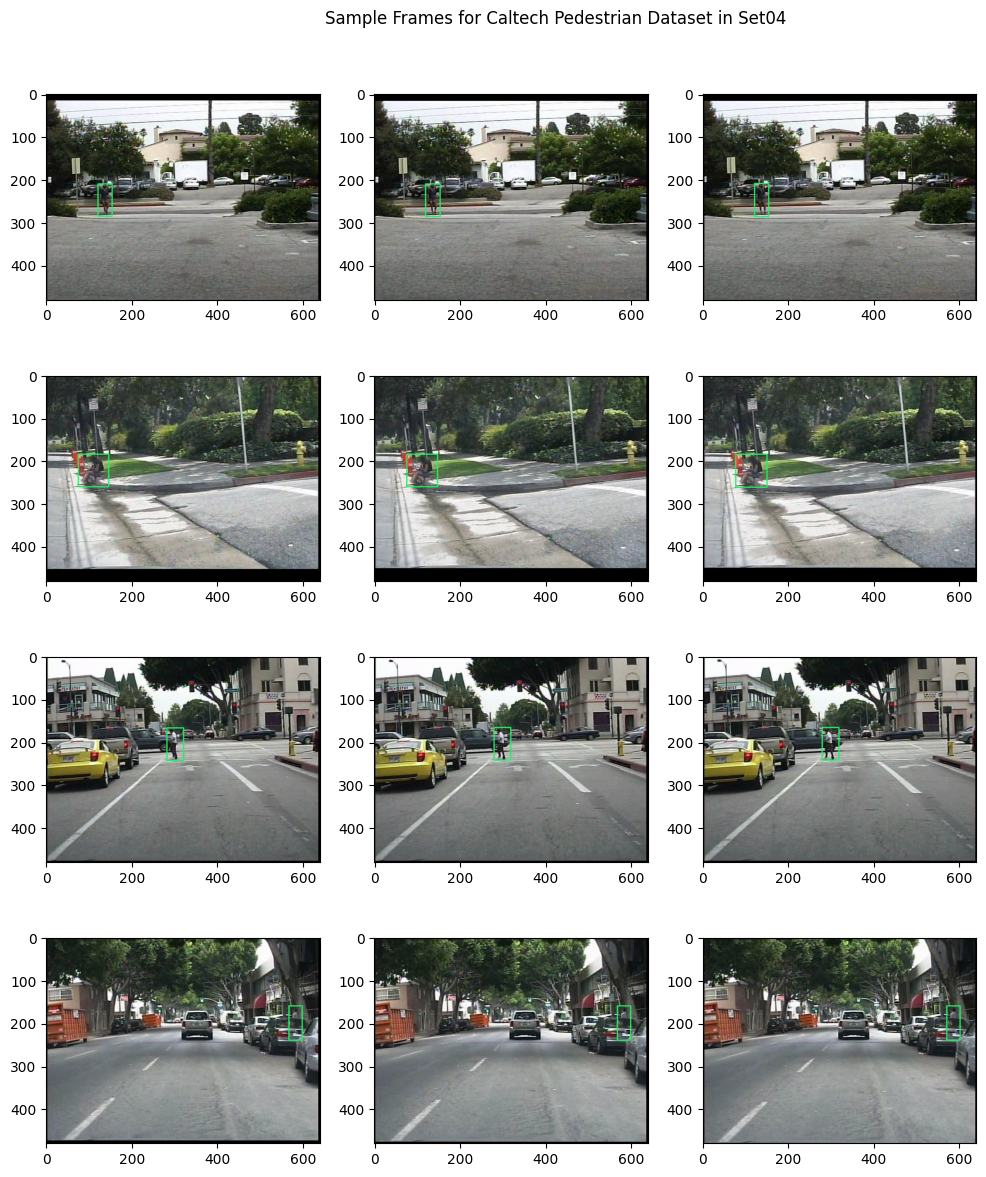

In [12]:
# Sample Frames for Caltech Pedestrian Dataset

# Create Subplots
n_rows = 4
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 14))

# Path
set_name = "set04"
set_image_path = "datasets/images/train/caltechpedestriandataset/{}".format(set_name)
set_label_path = "datasets/labels/train/caltechpedestriandataset/{}".format(set_name)
set_videos = sorted(os.listdir(set_image_path))
list_videos = list(set([x.split("_")[1] for x in set_videos]))
list_videos = sorted(list_videos)[:n_rows]

# Plot the Data
for i, vid_name in enumerate(list_videos):
    list_frames = sorted(glob.glob(set_image_path + "/{}_{}*".format(set_name, vid_name)))[:n_cols]
    
    for j, frame_path in enumerate(list_frames):
        frame_id = frame_path.split("/")[-1][:-4]
        
        # Read Image
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Read Text File
        label_frame = open(os.path.join(set_label_path, frame_id + ".txt"),'r').readlines()
        
        # Bounding Box
        for line in label_frame:
            list_box = [float(x) for x in line[:-1].split(" ")][1:]
            list_box = convert_yolo_to_coco(list_box)
            x1, y1, x2, y2 = list_box
            cv2.rectangle(frame, (x1, y1), (x2, y2), (30, 240, 100), 2)
        
        # Show Image
        axs[i, j].imshow(frame)
#         axs[i, j].axis("off")

# Title
plt.suptitle("Sample Frames for Caltech Pedestrian Dataset in {}".format(set_name.capitalize()), x=0.55, y=0.93)

# Show
plt.show()

<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">3.2. Sample Videos</h2>
</div>

In [13]:
# Get Frame Segments from Set00
set00_frames = sorted(os.listdir("datasets/images/train/caltechpedestriandataset/set00"))
frame_segment = []
frame_segment_list = []
check_segment = False
for i in range(len(set00_frames)):
    num_frame = int(set00_frames[i].split("_")[-1][:4])
    if(check_segment==False or num_frame-1==frame_segment[-1]):
        check_segment = True
        frame_segment.append(num_frame)
    else:
        print(set00_frames[i])
        check_segment = False
        frame_segment_list.append(frame_segment)
        frame_segment = [num_frame]
        if(len(frame_segment_list)==10):
            break

len_frame_segment = [len(x) for x in frame_segment_list]
print(len_frame_segment)

set00_V001_0358.png
set00_V001_0393.png
set00_V001_0500.png
set00_V001_0536.png
set00_V001_0903.png
set00_V002_0108.png
set00_V004_0000.png
set00_V004_0537.png
set00_V004_1067.png
set00_V006_0000.png
[8, 33, 28, 10, 38, 182, 226, 16, 28, 32]


In [14]:
# Convert Frames to Video
def convert_frames2video(frame_list, output):
    # Parameters
    fps = 25.0
    frame_size = (640, 480)
    
    # Create Video Writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output, fourcc, fps, frame_size)
    
    # Write frames to video writer
    for frame in frame_list:
        video.write(cv2.imread(frame))

    # Close video writer
    video.release()
    
    print("The output video is:", output)

In [15]:
# Get Frames from Segment #6
frame_segment_choice = ["datasets/images/train/caltechpedestriandataset/set00/set00_V001_" + f"{x:04d}.png" for x in frame_segment_list[5]]
print(len(frame_segment_choice))
display(frame_segment_choice[:4])

convert_frames2video(frame_segment_choice, "sample_videos/sample_video_1.mp4")

182


['datasets/images/train/caltechpedestriandataset/set00/set00_V001_0903.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V001_0904.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V001_0905.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V001_0906.png']

The output video is: sample_videos/sample_video_1.mp4


In [16]:
!ffmpeg -i sample_videos/sample_video_1.mp4 sample_videos/sample_video_1.webm

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [17]:
HTML("""
    <video width="640" height="480" controls>
      <source src="sample_videos/sample_video_1.webm" type="video/webm">
    </video>
""")

In [18]:
# Get Frames from Segment #7
frame_segment_choice = ["datasets/images/train/caltechpedestriandataset/set00/set00_V002_" + f"{x:04d}.png" for x in frame_segment_list[6]]
print(len(frame_segment_choice))
display(frame_segment_choice[:4])

convert_frames2video(frame_segment_choice, "sample_videos/sample_video_2.mp4")

226


['datasets/images/train/caltechpedestriandataset/set00/set00_V002_0108.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V002_0109.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V002_0110.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V002_0111.png']

The output video is: sample_videos/sample_video_2.mp4


In [19]:
!ffmpeg -i sample_videos/sample_video_2.mp4 sample_videos/sample_video_2.webm

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [20]:
HTML("""
    <video width="640" height="480" controls>
      <source src="sample_videos/sample_video_2.webm" type="video/webm">
    </video>
""")

<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">3.3. People Distribution per Frame</h2>
</div>

In [21]:
df_train_metadata = pd.read_csv("csv_files/train_frame_filtered.csv")
df_val_metadata = pd.read_csv("csv_files/val_frame_filtered.csv")

df_train_num_annot = df_train_metadata.groupby("num_annot")["image_id"].count().reset_index()
df_train_num_annot = df_train_num_annot.rename(columns={"image_id": "total_image"})
display(df_train_num_annot)

df_val_num_annot = df_val_metadata.groupby("num_annot")["image_id"].count().reset_index()
df_val_num_annot = df_val_num_annot.rename(columns={"image_id": "total_image"})
display(df_val_num_annot)

,num_annot,total_image
0,1,5800
1,2,2515
2,3,828
3,4,347
4,5,139
5,6,114
6,7,26
7,8,3
8,9,10
9,10,3


,num_annot,total_image
0,1,1598
1,2,773
2,3,118
3,4,9


In [22]:
# Create Subplot
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Training", "Validation"),
)

# Vertical Bar Chart
fig.add_trace(
    go.Bar(
        x=df_train_num_annot["num_annot"],
        y=df_train_num_annot["total_image"],
        name="Training",
        marker_color="#9f424d"
    ), row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=df_val_num_annot["num_annot"],
        y=df_val_num_annot["total_image"],
        name="Validation",
        marker_color="#4083d9"
    ), row=1, col=2
)

# Update Axes
fig.update_xaxes(linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(linecolor="Black", ticks="outside", row=1, col=2)

# Update Layout
fig.update_layout(
    title="People Distribution per Frame", title_x=0.5, font_family="Cambria",
    width=950, height=400,
    plot_bgcolor="White",
    showlegend=False,
)

# Show
fig.show(renderer="iframe_connected")

<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">3.4. Size and Aspect Ratio of People</h2>
</div>

In [23]:
# Create Annot DataFrame
def get_annot_dataframe(df):
    image_id_list = []
    label_list = []
    for i in range(len(df)):
        image_id = df["image_id"][i]
        labels = df["label"][i].split("\n")[:-1]
        for j in range(len(labels)):
            list_box = [float(x) for x in labels[j][:-1].split(" ")][1:]
            list_box = convert_yolo_to_coco(list_box)
            image_id_list.append(image_id)
            label_list.append(list_box)
            
    df_annot = pd.DataFrame({
        "image_id": image_id_list,
        "label": label_list
    })
    df_annot["x1"] = df_annot["label"].apply(lambda x: x[0])
    df_annot["y1"] = df_annot["label"].apply(lambda x: x[1])
    df_annot["x2"] = df_annot["label"].apply(lambda x: x[2])
    df_annot["y2"] = df_annot["label"].apply(lambda x: x[3])
    df_annot["p_width"] = df_annot["x2"] - df_annot["x1"]
    df_annot["p_height"] = df_annot["y2"] - df_annot["y1"]
    df_annot["area"] = df_annot["p_width"] * df_annot["p_height"]
    df_annot["aspect_ratio"] = df_annot["p_width"] / df_annot["p_height"]
    df_annot = df_annot.drop("label", axis=1)

    return df_annot

df_train_annot = get_annot_dataframe(df_train_metadata)
df_val_annot = get_annot_dataframe(df_val_metadata)

display(df_train_annot)
display(df_val_annot)

,image_id,x1,y1,x2,y2,p_width,p_height,area,aspect_ratio
0,set00_V001_0043,573,156,595,231,22,75,1650,0.293333
1,set00_V001_0044,578,156,599,231,21,75,1575,0.280000
2,set00_V001_0045,582,155,603,232,21,77,1617,0.272727
3,set00_V001_0046,587,155,608,237,21,82,1722,0.256098
4,set00_V001_0047,591,155,612,241,21,86,1806,0.244186
...,...,...,...,...,...,...,...,...,...
19360,set05_V012_0466,508,146,548,254,40,108,4320,0.370370
19361,set05_V012_0466,470,148,511,266,41,118,4838,0.347458
19362,set05_V012_0467,379,146,424,286,45,140,6300,0.321429
19363,set05_V012_0467,511,146,552,256,41,110,4510,0.372727


,image_id,x1,y1,x2,y2,p_width,p_height,area,aspect_ratio
0,set06_V000_0272,64,179,98,257,34,78,2652,0.435897
1,set06_V000_0273,63,180,97,258,34,78,2652,0.435897
2,set06_V000_0274,61,180,95,259,34,79,2686,0.430380
3,set06_V000_0275,60,180,94,260,34,80,2720,0.425000
4,set06_V000_0276,58,179,93,261,35,82,2870,0.426829
...,...,...,...,...,...,...,...,...,...
3529,set10_V011_0362,398,178,439,288,41,110,4510,0.372727
3530,set10_V011_0363,555,166,606,289,51,123,6273,0.414634
3531,set10_V011_0363,398,178,439,289,41,111,4551,0.369369
3532,set10_V011_0364,556,166,608,290,52,124,6448,0.419355


In [24]:
def get_annot_variation_dataframe(df_met, df_annot):
    df_met = df_met[df_met["num_annot"]>1].reset_index(drop=True)
    df_met_image_id = list(df_met["image_id"].unique())
    df_annot = df_annot[df_annot["image_id"].isin(df_met_image_id)].reset_index(drop=True)
    
    df_annot = df_annot.groupby(["image_id"]).agg({
        "p_width": ["min", "max"],
        "p_height": ["min", "max"],
        "area": ["min", "max"],
        "aspect_ratio": ["min", "max"],
    }).reset_index()
    columns = ['_'.join(col) for col in df_annot.columns]
    df_annot.columns = columns
    df_annot = df_annot.rename(columns={"image_id_": "image_id"})
    
    df_annot["p_width_range"] = df_annot["p_width_max"] - df_annot["p_width_min"]
    df_annot["p_height_range"] = df_annot["p_height_max"] - df_annot["p_height_min"]
    df_annot["area_range"] = df_annot["area_max"] - df_annot["area_min"]
    df_annot["aspect_ratio_range"] = df_annot["aspect_ratio_max"] - df_annot["aspect_ratio_min"]
    df_annot = df_annot.drop(list(df_annot.columns[1:9]), axis=1)
    
    return df_annot

df_train_annot_var = get_annot_variation_dataframe(df_train_metadata, df_train_annot)
df_val_annot_var = get_annot_variation_dataframe(df_val_metadata, df_val_annot)
display(df_train_annot_var)
display(df_val_annot_var)

,image_id,p_width_range,p_height_range,area_range,aspect_ratio_range
0,set00_V001_0368,5,9,605,0.030960
1,set00_V001_0369,5,9,601,0.032317
2,set00_V001_0370,10,10,1010,0.094044
3,set00_V001_0371,16,10,1488,0.170163
4,set00_V001_0372,23,9,2074,0.254635
...,...,...,...,...,...
4195,set05_V012_0463,4,33,1860,0.066231
4196,set05_V012_0464,5,32,1824,0.061086
4197,set05_V012_0465,5,31,1925,0.048891
4198,set05_V012_0466,5,30,1890,0.044283


,image_id,p_width_range,p_height_range,area_range,aspect_ratio_range
0,set06_V002_0146,4,9,538,0.016409
1,set06_V002_0147,3,10,488,0.000306
2,set06_V002_0148,2,10,414,0.012838
3,set06_V002_0149,4,11,605,0.008117
4,set06_V002_0150,3,11,531,0.004322
...,...,...,...,...,...
895,set10_V011_0360,11,13,1886,0.050037
896,set10_V011_0361,10,13,1763,0.041907
897,set10_V011_0362,11,13,1886,0.050037
898,set10_V011_0363,10,12,1722,0.045265


In [25]:
# Size Plot

# Create Subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=["Width Distribution", "Width Range Variations", "Height Distribution", "Height Range Variations"]
)

train_color = "#9f424d"
valid_color = "#4083d9"

parameter = ["width", "height"]
for i, param in enumerate(parameter):
    fig_distplot = ff.create_distplot(
        [df_train_annot["p_{}".format(param)], df_val_annot["p_{}".format(param)]], 
        ["Training", "Validation"], 
        show_rug=False
    )
    
    fig.add_trace(go.Histogram(fig_distplot['data'][0], marker_color=train_color, hoverinfo="skip"), row=i+1, col=1)
    fig.add_trace(go.Histogram(fig_distplot['data'][1], marker_color=valid_color, hoverinfo="skip"), row=i+1, col=1)
    fig.add_trace(go.Scatter(fig_distplot['data'][2], line=dict(color=train_color, width=2)), row=i+1, col=1)
    fig.add_trace(go.Scatter(fig_distplot['data'][3], line=dict(color=valid_color, width=2)), row=i+1, col=1)
    
    fig_distvars = ff.create_distplot(
        [df_train_annot_var["p_{}_range".format(param)], df_val_annot_var["p_{}_range".format(param)]], 
        ["Training", "Validation"], 
        show_rug=False
    )
    
    fig.add_trace(go.Histogram(fig_distvars['data'][0], marker_color=train_color, hoverinfo="skip"), row=i+1, col=2)
    fig.add_trace(go.Histogram(fig_distvars['data'][1], marker_color=valid_color, hoverinfo="skip"), row=i+1, col=2)
    fig.add_trace(go.Scatter(fig_distvars['data'][2], line=dict(color=train_color, width=2)), row=i+1, col=2)
    fig.add_trace(go.Scatter(fig_distvars['data'][3], line=dict(color=valid_color, width=2)), row=i+1, col=2)
    
    # Update Axes
    fig.update_xaxes(linecolor="Black", ticks="outside", row=i+1, col=1)
    fig.update_yaxes(linecolor="Black", ticks="outside", row=i+1, col=1)
    fig.update_xaxes(linecolor="Black", ticks="outside", row=i+1, col=2)
    fig.update_yaxes(linecolor="Black", ticks="outside", row=i+1, col=2)

# Update Layout
fig.update_layout(
    title="<b>Size Plot</b>", title_x=0.5, font_family="Cambria",
    width=950, height=550,
    plot_bgcolor="White",
    showlegend=False,
)

# Show
fig.show(renderer="iframe_connected")

In [26]:
# Area Plot

# Create Subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Area Distribution", "Area Range Variations"]
)

train_color = "#9f424d"
valid_color = "#4083d9"

# Distributions
fig_distplot = ff.create_distplot(
    [df_train_annot["area"], df_val_annot["area"]], 
    ["Training", "Validation"], 
    bin_size=.5,
    show_rug=False
)

fig.add_trace(go.Scatter(fig_distplot['data'][2], line=dict(color=train_color, width=2)), row=1, col=1)
fig.add_trace(go.Scatter(fig_distplot['data'][3], line=dict(color=valid_color, width=2)), row=1, col=1)

# Range Variations
fig_distvars = ff.create_distplot(
    [df_train_annot_var["area_range"], df_val_annot_var["area_range"]], 
    ["Training", "Validation"], 
    bin_size=.5,
    show_rug=False
)
    
fig.add_trace(go.Scatter(fig_distvars['data'][2], line=dict(color=train_color, width=2)), row=1, col=2)
fig.add_trace(go.Scatter(fig_distvars['data'][3], line=dict(color=valid_color, width=2)), row=1, col=2)
    
# Update Axes
for i in range(2):
    fig.update_xaxes(linecolor="Black", ticks="outside", row=1, col=i+1)
    fig.update_yaxes(linecolor="Black", ticks="outside", row=1, col=i+1)

# Update Layout
fig.update_layout(
    title="<b>Area Plot</b>", title_x=0.5, font_family="Cambria",
    width=950, height=400,
    plot_bgcolor="White",
    showlegend=False,
)

# Show
fig.show(renderer="iframe_connected")

In [27]:
# Aspect Plot

# Create Subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Aspect Ratio Distribution", "Aspect Ratio Range Variations"]
)

train_color = "#9f424d"
valid_color = "#4083d9"

# Distributions
fig_distplot = ff.create_distplot(
    [df_train_annot["aspect_ratio"], df_val_annot["aspect_ratio"]], 
    ["Training", "Validation"], 
    bin_size=.5,
    show_rug=False
)

fig.add_trace(go.Scatter(fig_distplot['data'][2], line=dict(color=train_color, width=2)), row=1, col=1)
fig.add_trace(go.Scatter(fig_distplot['data'][3], line=dict(color=valid_color, width=2)), row=1, col=1)

# Range Variations
fig_distvars = ff.create_distplot(
    [df_train_annot_var["aspect_ratio_range"], df_val_annot_var["aspect_ratio_range"]], 
    ["Training", "Validation"], 
    bin_size=.5,
    show_rug=False
)
    
fig.add_trace(go.Scatter(fig_distvars['data'][2], line=dict(color=train_color, width=2)), row=1, col=2)
fig.add_trace(go.Scatter(fig_distvars['data'][3], line=dict(color=valid_color, width=2)), row=1, col=2)

# Update Axes
for i in range(2):
    fig.update_xaxes(linecolor="Black", ticks="outside", row=1, col=i+1)
    fig.update_yaxes(linecolor="Black", ticks="outside", row=1, col=i+1)

# Update Layout
fig.update_layout(
    title="<b>Aspect Ratio Plot</b>", title_x=0.5, font_family="Cambria",
    width=950, height=400,
    plot_bgcolor="White",
    showlegend=False,
)

# Show
fig.show(renderer="iframe_connected")

<div>
    <h1 id = "object-detection"
        style = "background-color: #9f424d;
                 border-radius: 25px;
                 border-left:40px #b3b6b5 solid;
                 border-right:40px #b3b6b5 solid;
                 color: #f8f8f8;
                 line-height: 28px;
                 padding: 14px 0px 15px 15px; 
                 text-align: center;
                 font-size: 25px;
                 font-weight: bold;
                 font-family: Cambria;">4. Object Detection - YOLOv8 🕵🏻
        <a class="anchor-link" id="object-detection" href="https://www.kaggle.com/harits/people-detection-and-tracking-yolov8-bytetrack#object-detection">¶</a>
    </h1>
</div>

<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">4.1. YOLOv8 Preparation</h2>
</div>

In [28]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 22.7 MB/s eta 0:00:00


In [29]:
%%writefile /kaggle/working/custom_dataset.yaml
# Create Custom Dataset Configuration
path: /kaggle/working/datasets
train: /kaggle/working/datasets/images/train
val: /kaggle/working/datasets/images/val
    
nc: 1
    
names: [
    'person'
]

Writing /kaggle/working/custom_dataset.yaml


<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">4.2. YOLOv8 Training</h2>
</div>

In [30]:
!wandb disabled
!pip install GPUtil

W&B disabled.
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=ba4d49a2dddabe0f44ea6b629d583bc2ef30270fc12acd9302e2ffbc5d63f2ab
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [31]:
from GPUtil import showUtilization as gpu_usage
import torch
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  5% |  1% |
|  1 |  0% |  0% |


In [32]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")
model.train(data="/kaggle/working/custom_dataset.yaml", epochs=3, verbose=True, batch=64)

100%|██████████| 21.5M/21.5M [00:00<00:00, 202MB/s]


Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/custom_dataset.yaml, epochs=3, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 19.7MB/s]
2024-04-24 14:14:31,303	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-24 14:14:32,171	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-24 14:14:34.920536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 14:14:34.920643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 14:14:35.097859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 116MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/labels/train/caltechpedestriandataset/set00... 10000 images, 0 backgrounds, 2 corrupt: 100%|██████████| 10000/10000 [00:32<00:00, 311.19it/s]

train: WARNING ⚠️ /kaggle/working/datasets/images/train/caltechpedestriandataset/set00/set00_V007_0985.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0008]
train: WARNING ⚠️ /kaggle/working/datasets/images/train/caltechpedestriandataset/set00/set00_V014_0613.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0004]


train: New cache created: /kaggle/working/datasets/labels/train/caltechpedestriandataset/set00.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/datasets/labels/val/caltechpedestriandataset/set06... 2498 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2498/2498 [00:07<00:00, 323.39it/s]


val: New cache created: /kaggle/working/datasets/labels/val/caltechpedestriandataset/set06.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      14.9G      1.548      1.663      1.245         40        640: 100%|██████████| 157/157 [02:30<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]

                   all       2498       3534      0.587      0.407      0.433      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      15.5G      1.395      1.025      1.192         37        640: 100%|██████████| 157/157 [02:31<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


                   all       2498       3534       0.67      0.684      0.605      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      14.4G      1.266     0.8708      1.132         40        640: 100%|██████████| 157/157 [02:31<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]

                   all       2498       3534      0.706      0.729      0.705      0.382



3 epochs completed in 0.144 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


                   all       2498       3534      0.706      0.729      0.705      0.382
Speed: 0.1ms preprocess, 3.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7885e4107af0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">4.3. YOLOv8 Evaluation</h2>
</div>

In [33]:
metrics = model.val()  # evaluate model performance on the validation set

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/working/datasets/labels/val/caltechpedestriandataset/set06.cache... 2498 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2498/2498 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


                   all       2498       3534      0.706      0.729      0.705      0.383
Speed: 0.2ms preprocess, 7.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train2


<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">4.4. Loss and Metrics Evaluation</h2>
</div>

In [34]:
training_results = pd.read_csv("/kaggle/working/runs/detect/train{}/results.csv".format(train_fol))
list_column = [col.strip() for col in training_results.columns]
training_results.columns = list_column

training_results

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.5476,1.66290,1.2454,0.58702,0.40747,0.43308,0.20336,2.1439,2.1889,1.7002,0.000662,0.000662,0.000662
1,2,1.3955,1.02490,1.1920,0.67028,0.68421,0.60513,0.33062,1.6172,1.5382,1.3040,0.000890,0.000890,0.000890
2,3,1.2660,0.87077,1.1317,0.70612,0.72864,0.70488,0.38200,1.6954,1.1916,1.2926,0.000679,0.000679,0.000679


In [35]:
# Training and Validation Loss

# Create Subplot
fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=["Localization Loss", "Classification Loss", "Distributional Focal Loss"], 
)

# Configuration Plot
class PlotCFG:
    marker_size = 6.5
    line_size = 2
    train_color = "#9f424d"
    valid_color = "#4083d9"

loss_list = ["box_loss", "cls_loss", "dfl_loss"]
for i, loss in enumerate(loss_list):
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["train/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.train_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
            name="Training"
        ), row=1, col=i+1
    )
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["val/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=1, col=i+1
    )

# Update Axes
ticklabels = ["Box Loss", "Cls Loss", "DFL Loss"]
for i, ticklabel in enumerate(ticklabels):
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=i+1)
    fig.update_yaxes(title=ticklabel, linecolor="Black", ticks="outside", row=1, col=i+1)

# Update Layout
fig.update_layout(
    title="Training and Validation Loss", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=350,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

In [36]:
# Validation Metrics

# Create Subplot
subplot_titles = ["Precision", "Recall", "mAP50", "mAP50-95"]
fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=subplot_titles, 
)

# Configuration Plot
class PlotCFG:
    marker_size = 7
    line_size = 2
    train_color = "#9f424d"
    valid_color = "#4083d9"

metrics = ["precision", "recall", "mAP50", "mAP50-95"]
for i, metric in enumerate(metrics):
    # Plot
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["metrics/{}(B)".format(metric)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=(i//2)+1, col=(i%2)+1
    )
    
    # Update Axes
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)
    fig.update_yaxes(title=subplot_titles[i], linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)

# Update Layout
fig.update_layout(
    title="Validation Metrics", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=600,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

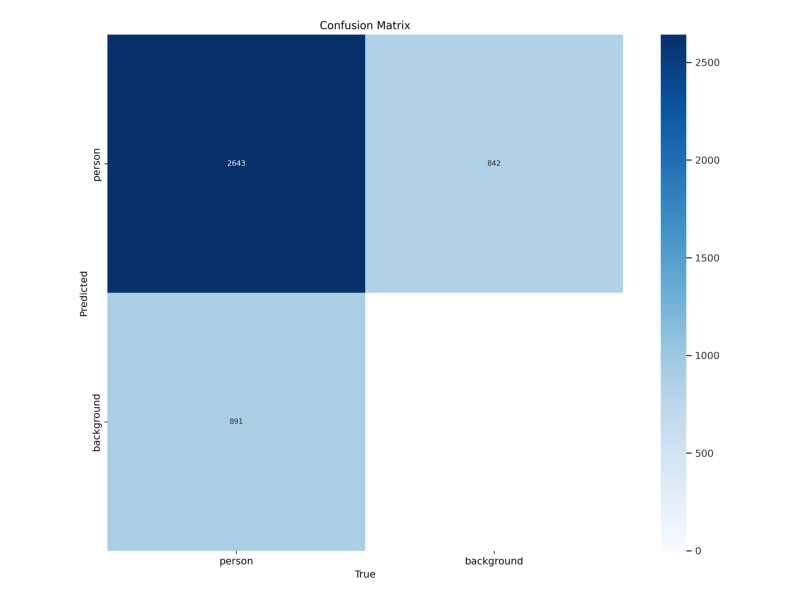

In [38]:
# Confusion Matrix
fig = plt.figure(figsize=(10, 9))
cm_img = mpimg.imread("/kaggle/working/runs/detect/train2/confusion_matrix.png".format(val_fol))
plt.imshow(cm_img)
plt.axis("off")
fig.show()

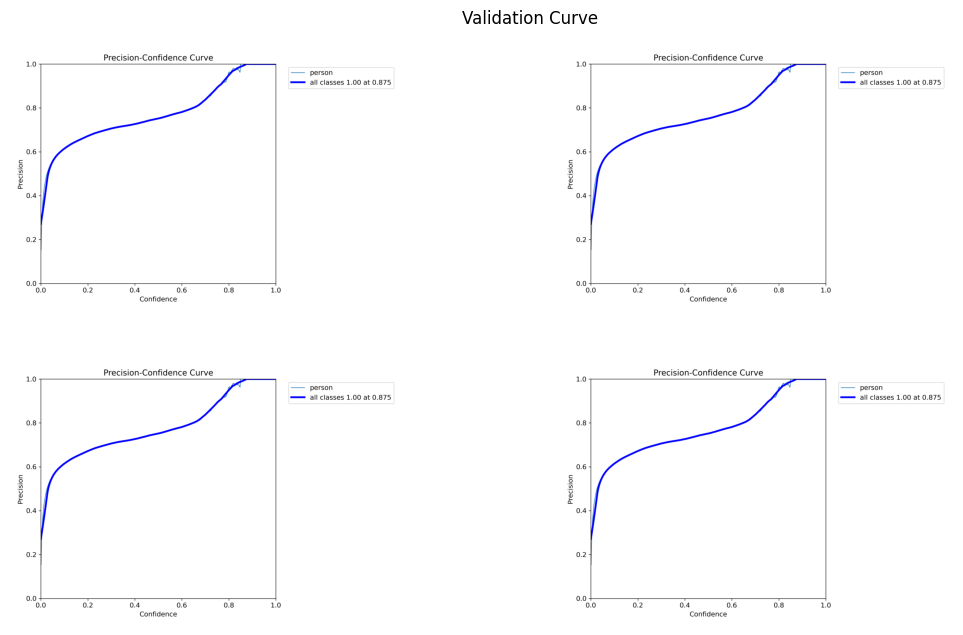

In [41]:
# Validation Curve
fig, axs = plt.subplots(2, 2, figsize=(13, 7.5))
curve_list = ["P_curve", "R_curve", "F1_curve", "PR_curve"]
for i, curve in enumerate(curve_list):
    curve_path = "/kaggle/working/runs/detect/train2/P_curve.png".format(val_fol, curve)
    curve_img = mpimg.imread(curve_path)
    axs[i//2, i%2].imshow(curve_img)
    axs[i//2, i%2].axis('off')
    
# Title
plt.suptitle("Validation Curve", x=0.55, y=0.93)

# Show
plt.show()

<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">4.5. Test Object Detection in Videos</h2>
</div>

In [42]:
# Get Frames from Segment #6
frame_segment_choice = ["datasets/images/train/caltechpedestriandataset/set00/set00_V001_" + f"{x:04d}.png" for x in frame_segment_list[5]]
print(len(frame_segment_choice))
display(frame_segment_choice[:4])

182


['datasets/images/train/caltechpedestriandataset/set00/set00_V001_0903.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V001_0904.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V001_0905.png',
 'datasets/images/train/caltechpedestriandataset/set00/set00_V001_0906.png']

In [43]:
def detect_people(frame_list):
    yolo_model = YOLO('/kaggle/working/runs/detect/train{}/weights/best.pt'.format(train_fol))
    bbox_results = yolo_model.predict(frame_list, verbose=False)
    all_box_list = []
    all_conf_list = []
    for bbox_result in bbox_results:
        boxes = bbox_result.boxes
        box_list = []
        conf_list = []
        for box in boxes:
            box_data = box.data[0][:4]
            box_data = [int(x) for x in box_data]
            conf = round(float(box.conf), 2)
            if(conf>=0.5):
                box_list.append(box_data)
                conf_list.append(conf)

        all_box_list.append(box_list)
        all_conf_list.append(conf_list)
    
    box_results = pd.DataFrame({
        "box_list": all_box_list,
        "conf_list": all_conf_list
    })
    return box_results

out_box_results = detect_people(frame_segment_choice)

In [44]:
def show_people_detection(frame_list, box_results, output):
    # Parameters
    fps = 20.0
    frame_size = (640, 480)
    
    # Create Video Writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output, fourcc, fps, frame_size)
    
    # Write Frames to Video Writer
    for i, frame_path in enumerate(frame_list):
        # Read Frame
        frame = cv2.imread(frame_path)
        
        box_list = box_results.loc[i, "box_list"]
        conf_list = box_results.loc[i, "conf_list"]
        if(len(box_list)>0):
            # For Each Box
            for j, box in enumerate(box_list):
                # Get Bounding Box
                x1, y1, x2, y2 = box
                
                # Draw Bounding Box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (30, 240, 100), 2)
                cv2.rectangle(frame, (x1-10, y1-25), (x2+10, y1), (30, 240, 100), -1)
                
                # Create Text Align for Confidence Score
                font = cv2.FONT_HERSHEY_SIMPLEX
                text = 'Conf: ' + str(conf_list[j])
                
                textsize = cv2.getTextSize(text, font, 0.5, 2)[0]
                textX = ((x2 - x1 + 20) - textsize[0]) // 2
                textY = (25 + textsize[1]) // 2
                
                # Assign Confidence Score to Frame
                cv2.putText(frame, text, (x1 - 10 + textX, y1 - 25 + textY), font, 0.5, (0, 0, 0), 2)
            
        video.write(frame)
        
    # Close video writer
    video.release()
    
show_people_detection(frame_segment_choice, out_box_results, "output_videos/output_video_detect_1.mp4")

In [45]:
!ffmpeg -i output_videos/output_video_detect_1.mp4 output_videos/output_video_detect_1.webm

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [46]:
HTML("""
    <video width="640" height="480" controls>
      <source src="output_videos/output_video_detect_1.webm" type="video/webm">
    </video>
""")

<div>
    <h1 id = "object-tracking"
        style = "background-color: #9f424d;
                 border-radius: 25px;
                 border-left:40px #b3b6b5 solid;
                 border-right:40px #b3b6b5 solid;
                 color: #f8f8f8;
                 line-height: 28px;
                 padding: 14px 0px 15px 15px; 
                 text-align: center;
                 font-size: 25px;
                 font-weight: bold;
                 font-family: Cambria;">5. Object Tracking - ByteTrack ⏭️
        <a class="anchor-link" id="object-tracking" href="https://www.kaggle.com/harits/people-detection-and-tracking-yolov8-bytetrack#object-tracking">¶</a>
    </h1>
</div>

<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">5.1. ByteTrack Preparation</h2>
</div>

In [47]:
!git clone https://github.com/mikel-brostrom/yolov8_tracking.git
!pip install -r yolov8_tracking/requirements.txt

Cloning into 'yolov8_tracking'...
remote: Enumerating objects: 11355, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 11355 (delta 1), reused 2 (delta 1), pack-reused 11349
Receiving objects: 100% (11355/11355), 111.12 MiB | 41.15 MiB/s, done.
Resolving deltas: 100% (7004/7004), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'yolov8_tracking/requirements.txt'


<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">5.2. YOLOv8 and ByteTrack Integration</h2>
</div>

In [48]:
%cd yolov8_tracking
!python track.py --source /kaggle/working/sample_videos/sample_video_1.mp4 --yolo-model /kaggle/working/runs/detect/train/weights/best.pt --reid-model osnet_x0_25_market1501.pt
%cd ..

/kaggle/working/yolov8_tracking
python: can't open file '/kaggle/working/yolov8_tracking/track.py': [Errno 2] No such file or directory
/kaggle/working


<div>
    <h2 style = "color: #44101c; font-size: 22px; font-family: Cambria; font-weight: bold;">5.3. Test Object Tracking in Videos</h2>
</div>

In [49]:
def track_people(frame_list, output):   
    # Parameters
    fps = 20.0
    frame_size = (640, 480)
    
    # Create Video Writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output, fourcc, fps, frame_size)
    
    # Write frames to video writer
    colors = sns.color_palette('colorblind')
    for i, frame_path in enumerate(frame_list):
        # Read Frame
        frame = cv2.imread(frame_path)
        
        label_path = "yolov8_tracking/runs/track/exp{}/labels/sample_video_1_{}.txt".format(track_fol, i+1)
        if(os.path.exists(label_path)):
            # Read Text File
            label_frame = open(label_path,'r').readlines()
            
            for line in label_frame:
                # Get Bounding Box and Re-ID
                list_box = [float(x) for x in line[:-1].split(" ")][1:]
                re_id = int(list_box[-1])
                list_box = list_box[:-1]
                list_box = convert_yolo_to_coco(list_box)
                x1, y1, x2, y2 = list_box
                
                # Draw Bounding Box
                color = colors[re_id%10]
                color = tuple([x * 255 for x in color])
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.rectangle(frame, (x1-10, y1-25), (x2+10, y1), color, -1)
                
                # Create Text Align for Re-ID
                font = cv2.FONT_HERSHEY_SIMPLEX
                text = 'ID: ' + str(re_id)
                
                textsize = cv2.getTextSize(text, font, 0.5, 2)[0]
                textX = ((x2 - x1 + 20) - textsize[0]) // 2
                textY = (25 + textsize[1]) // 2
                
                # Assign Re-ID to Frame
                cv2.putText(frame, text, (x1 - 10 + textX, y1 - 25 + textY), font, 0.5, (0, 0, 0), 2)
        video.write(frame)
        
    # Close video writer
    video.release()

In [50]:
track_people(frame_segment_choice, "output_videos/output_video_track_1.mp4")

In [51]:
!ffmpeg -i output_videos/output_video_track_1.mp4 output_videos/output_video_track_1.webm

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [52]:
HTML("""
    <video width="640" height="480" controls>
      <source src="output_videos/output_video_track_1.webm" type="video/webm">
    </video>
""")

<div class="alert alert-block alert-danger" style="color: black; font-size: 15px; font-family: Cambria">
    <b>References</b>:
    <ul>
        <li>Caltech-Pedestrian-Dataset - Kalvin Quackenbush: <a href="https://www.kaggle.com/datasets/kalvinquackenbush/caltechpedestriandataset"><u>https://www.kaggle.com/datasets/kalvinquackenbush/caltechpedestriandataset</u></a></li>
        <li>Convert the Format of the Caltech Pedestrian Dataset to the Format that YOLO Uses: <a href="https://github.com/simonzachau/caltech-pedestrian-dataset-to-yolo-format-converter"><u>https://github.com/simonzachau/caltech-pedestrian-dataset-to-yolo-format-converter</u></a></li>
        <li>Pedestrian Detection: A Benchmark</li>
        <li>Vehicle Count | YOLOv8 | ByteTrack Notebook - Umar Saeed: <a href="https://www.kaggle.com/code/ryzer97/vehicle-count-yolov8-bytetrack"><u>https://www.kaggle.com/code/ryzer97/vehicle-count-yolov8-bytetrack</u></a></li>
    </ul>
    <b>Improvements</b>:
    <ul>
        <li>Using larger datasets and training the object detection model longer to get more optimal results of person detection.</li>
        <li>Analyze more about the handling of variations in the size of the height of the bounding box of people for each frame.</li>
        <li>Leverage other tools to count people.</li>
    </ul>
</div>